---
## 따릉이 데이터 분석을 통한 이용량 예측
### 데이터 columns 기본 정보
- id 고유 id
- hour 시간
- temperature 기온
- precipitation 비가 오지 않았으면 0, 비가 오면 1
- windspeed 풍속(평균)
- humidity 습도
- visibility 시정(視程), 시계(視界)(특정 기상 상태에 따른 가시성을 의미)
- ozone 오존
- pm10 미세먼지(머리카락 굵기의 1/5에서 1/7 크기의 미세먼지)
- pm2.5 미세먼지(머리카락 굵기의 1/20에서 1/30 크기의 미세먼지)
- count 시간에 따른 따릉이 대여 수
---
### 방향성
- 회귀 방식을 사용, 데이터를 정제하고 예측 모델을 사용
- KNN, Decsion Tree + 앙상블 모델
- linear[rigde, lasso, Elastic-net]
- 데이터 scaling : 범위가 다를 가능성 농후
- ?, 0 과 같은 결측치 역시 대체 => 타 콜럼의 성격을 확인하고 대체
---

---
### 모듈 로딩 및 데이터 불러오기
---

In [1]:
from sklearn.utils import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression,Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor,ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.experimental  import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np
import seaborn as sns
from custom_function import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
ttareun_data = pd.read_csv('train.csv')
ttareun_data


,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0
...,...,...,...,...,...,...,...,...,...,...,...
1454,2174,4,16.8,0.0,1.6,53.0,2000.0,0.031,37.0,27.0,21.0
1455,2175,3,10.8,0.0,3.8,45.0,2000.0,0.039,34.0,19.0,20.0
1456,2176,5,18.3,0.0,1.9,54.0,2000.0,0.009,30.0,21.0,22.0
1457,2178,21,20.7,0.0,3.7,37.0,1395.0,0.082,71.0,36.0,216.0


---
### 결측치 확인
---

In [3]:
ttareun_data.info()
for i in ttareun_data.columns:
    print(ttareun_data[i].value_counts())
#Insight!
#얘네 모두 다 다른 자전거네

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1459 non-null   int64  
 1   hour                    1459 non-null   int64  
 2   hour_bef_temperature    1457 non-null   float64
 3   hour_bef_precipitation  1457 non-null   float64
 4   hour_bef_windspeed      1450 non-null   float64
 5   hour_bef_humidity       1457 non-null   float64
 6   hour_bef_visibility     1457 non-null   float64
 7   hour_bef_ozone          1383 non-null   float64
 8   hour_bef_pm10           1369 non-null   float64
 9   hour_bef_pm2.5          1342 non-null   float64
 10  count                   1459 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 125.5 KB
3       1
1481    1
1479    1
1478    1
1477    1
       ..
747     1
744     1
743     1
742     1
2179    1
Name: id, Length: 1459, dtype: int64
20   

##### [1] 온도결측치

In [4]:
#결측치 확인 - 1 온도 결측치
x = ttareun_data[ttareun_data['hour_bef_temperature'].isnull() ==True].index
print(x)


Int64Index([934, 1035], dtype='int64')


In [5]:
#해당 데이터의 경우 id와 대여수만 존재하므로 결측치를 대체하기가 애매함.
#같은 아이디를 공유하는 데이터를 확인
# 같은 아이디를 공유하는 데이터가 없음을 확인 두 컬럼은 삭제해도 무방할듯
ttareun_data.drop(x ,inplace=True)
ttareun_data.reset_index(inplace=True)
ttareun_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1457 entries, 0 to 1456
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   index                   1457 non-null   int64  
 1   id                      1457 non-null   int64  
 2   hour                    1457 non-null   int64  
 3   hour_bef_temperature    1457 non-null   float64
 4   hour_bef_precipitation  1457 non-null   float64
 5   hour_bef_windspeed      1450 non-null   float64
 6   hour_bef_humidity       1457 non-null   float64
 7   hour_bef_visibility     1457 non-null   float64
 8   hour_bef_ozone          1383 non-null   float64
 9   hour_bef_pm10           1369 non-null   float64
 10  hour_bef_pm2.5          1342 non-null   float64
 11  count                   1457 non-null   float64
dtypes: float64(9), int64(3)
memory usage: 136.7 KB


##### [2] 풍속 결측치

In [6]:
ttareun_data[ttareun_data.hour_bef_windspeed.isnull() ==True]

,index,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
18,18,33,13,22.6,0.0,NaN,41.0,987.0,0.046,64.0,39.0,208.0
244,244,381,1,14.1,0.0,NaN,55.0,1992.0,NaN,NaN,NaN,38.0
260,260,404,3,14.0,0.0,NaN,50.0,2000.0,0.049,35.0,22.0,17.0
376,376,570,0,14.3,0.0,NaN,49.0,2000.0,0.044,37.0,20.0,58.0
780,780,1196,20,16.5,0.0,NaN,31.0,2000.0,0.058,39.0,18.0,181.0
1136,1138,1717,12,21.4,0.0,NaN,44.0,1375.0,0.044,61.0,37.0,116.0
1227,1229,1855,2,14.0,0.0,NaN,52.0,2000.0,0.044,37.0,20.0,20.0


In [7]:
na_index_list = ttareun_data[ttareun_data.hour_bef_windspeed.isnull() ==True].index
for i in na_index_list:
    ttareun_data['hour_bef_windspeed'][i] = round(ttareun_data[ttareun_data.hour==ttareun_data.iloc[i]['hour']].hour_bef_windspeed.mean(),2)
# 풍속은 날마다 다르기 때문에 함부로 아이디가 같다고 대체할 수 없음.
# 시간에 따른 평균 값으로 대체


In [8]:
ttareun_data.iloc[na_index_list]
#잘 대체된 모습이다.

,index,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
18,18,33,13,22.6,0.0,3.28,41.0,987.0,0.046,64.0,39.0,208.0
244,244,381,1,14.1,0.0,1.84,55.0,1992.0,NaN,NaN,NaN,38.0
260,260,404,3,14.0,0.0,1.62,50.0,2000.0,0.049,35.0,22.0,17.0
376,376,570,0,14.3,0.0,1.97,49.0,2000.0,0.044,37.0,20.0,58.0
780,780,1196,20,16.5,0.0,3.28,31.0,2000.0,0.058,39.0,18.0,181.0
1136,1138,1717,12,21.4,0.0,2.77,44.0,1375.0,0.044,61.0,37.0,116.0
1227,1229,1855,2,14.0,0.0,1.63,52.0,2000.0,0.044,37.0,20.0,20.0


##### [3] 오존, 미세먼지, 초미세먼지
##### chatgpt의 의견
- 온도: 고온일수록 오존 생성량이 증가합니다. 이는 이산화질소와 탄화수소 등의 오염물질이 일정 온도에서 화학 반응을 일으켜 오존이 생성되기 때문입니다.
- 풍속: 풍속이 강할수록 오존의 농도가 낮아집니다. 이는 오존이 바람에 의해 희석되고, 대기 중 다른 물질과 혼합되어 확산되기 때문입니다.
- 그러나 딱히 큰 영향X 상관관계 자체가 떨어짐 

In [9]:
#오존
print(ttareun_data[ttareun_data.hour_bef_ozone.isnull() ==True].hour.value_counts())
#1시 측정된 데이터에서의 오존 데이터가 많이 없음을 확인

1     61
16     3
17     2
10     1
18     1
12     1
7      1
11     1
15     1
6      1
13     1
Name: hour, dtype: int64


In [10]:
#시간대 별 오존 농도의 평균은 거의 유사함
print(round(ttareun_data[ttareun_data.hour == 0].hour_bef_ozone.mean(),3))
print(round(ttareun_data[ttareun_data.hour == 2].hour_bef_ozone.mean(),3))
print()
print('분포 역시 거의 유사할것으로 예상')
print(ttareun_data[ttareun_data.hour == 0].hour_bef_ozone.describe())
print(ttareun_data[ttareun_data.hour == 2].hour_bef_ozone.describe())
hour_0and2_ozone= pd.DataFrame(zip(ttareun_data[ttareun_data.hour == 0].hour_bef_ozone,ttareun_data[ttareun_data.hour == 2].hour_bef_ozone),columns=['0시','2시'])
hour_0and2_ozone.describe()
#시간대로 결측치를 추정해서 대체할까하다가 시간 부족으로 인해
#impute.iterative를 이용한 결측치 추정이 적합할 것으로 예상

0.034
0.03

분포 역시 거의 유사할것으로 예상
count    59.000000
mean      0.033763
std       0.016296
min       0.003000
25%       0.022500
50%       0.035000
75%       0.042500
max       0.074000
Name: hour_bef_ozone, dtype: float64
count    61.000000
mean      0.030492
std       0.016567
min       0.003000
25%       0.018000
50%       0.031000
75%       0.039000
max       0.083000
Name: hour_bef_ozone, dtype: float64


,0시,2시
count,59.000000,59.000000
mean,0.033763,0.030559
std,0.016296,0.016710
min,0.003000,0.003000
25%,0.022500,0.019000
50%,0.035000,0.031000
75%,0.042500,0.038500
max,0.074000,0.083000


(array([ 8.,  8.,  8., 12., 16.,  3.,  2.,  3.,  0.,  1.]),
 array([0.003, 0.011, 0.019, 0.027, 0.035, 0.043, 0.051, 0.059, 0.067,
        0.075, 0.083]),
 <BarContainer object of 10 artists>)

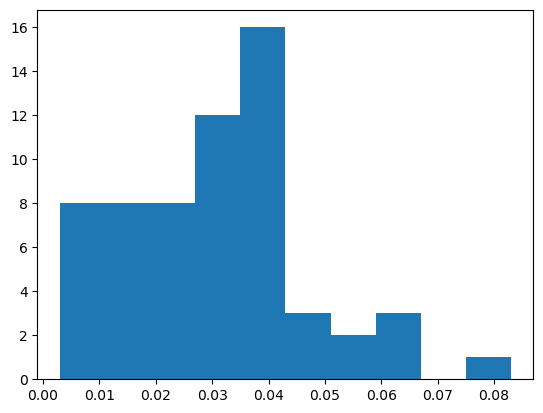

In [11]:
plt.hist(ttareun_data[ttareun_data.hour == 2].hour_bef_ozone)


(array([ 6.,  7.,  3.,  6., 16., 11.,  2.,  4.,  3.,  1.]),
 array([0.003 , 0.0101, 0.0172, 0.0243, 0.0314, 0.0385, 0.0456, 0.0527,
        0.0598, 0.0669, 0.074 ]),
 <BarContainer object of 10 artists>)

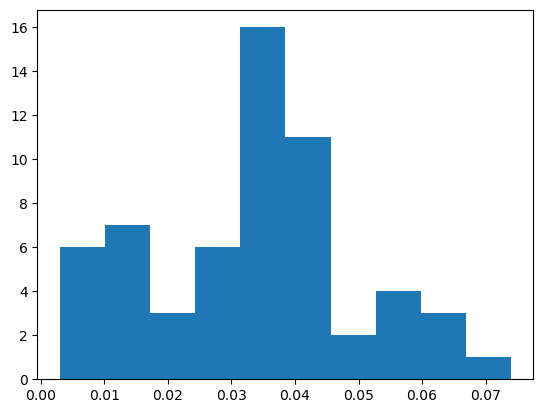

In [12]:
plt.hist(ttareun_data[ttareun_data.hour == 0].hour_bef_ozone)


In [13]:
#하기 전에 id와 index는 삭제
ttareun_data.drop(['id', 'index'],axis=1, inplace=True)

In [14]:
#나머지 결측치 대체  IterativeImputer
  
from sklearn.experimental  import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imputer = IterativeImputer()
ttareun_data_fill_na_array = imputer.fit_transform(ttareun_data)

In [15]:
ttareun_df = pd.DataFrame(ttareun_data_fill_na_array,columns=ttareun_data.columns)
ttareun_df

,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,20.0,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,13.0,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,6.0,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,23.0,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,18.0,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0
...,...,...,...,...,...,...,...,...,...,...
1452,4.0,16.8,0.0,1.6,53.0,2000.0,0.031,37.0,27.0,21.0
1453,3.0,10.8,0.0,3.8,45.0,2000.0,0.039,34.0,19.0,20.0
1454,5.0,18.3,0.0,1.9,54.0,2000.0,0.009,30.0,21.0,22.0
1455,21.0,20.7,0.0,3.7,37.0,1395.0,0.082,71.0,36.0,216.0


In [16]:
ttareun_df.info()
#결측치가 제거된 상태

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1457 entries, 0 to 1456
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   hour                    1457 non-null   float64
 1   hour_bef_temperature    1457 non-null   float64
 2   hour_bef_precipitation  1457 non-null   float64
 3   hour_bef_windspeed      1457 non-null   float64
 4   hour_bef_humidity       1457 non-null   float64
 5   hour_bef_visibility     1457 non-null   float64
 6   hour_bef_ozone          1457 non-null   float64
 7   hour_bef_pm10           1457 non-null   float64
 8   hour_bef_pm2.5          1457 non-null   float64
 9   count                   1457 non-null   float64
dtypes: float64(10)
memory usage: 114.0 KB


count    61.000000
mean      0.028964
std       0.006850
min       0.009526
25%       0.025588
50%       0.029009
75%       0.032362
max       0.053141
Name: hour_bef_ozone, dtype: float64
0.028964135776185885


(array([ 1.,  2.,  6., 13., 19., 12.,  5.,  2.,  0.,  1.]),
 array([0.00952587, 0.01388735, 0.01824883, 0.02261031, 0.02697178,
        0.03133326, 0.03569474, 0.04005622, 0.0444177 , 0.04877918,
        0.05314066]),
 <BarContainer object of 10 artists>)

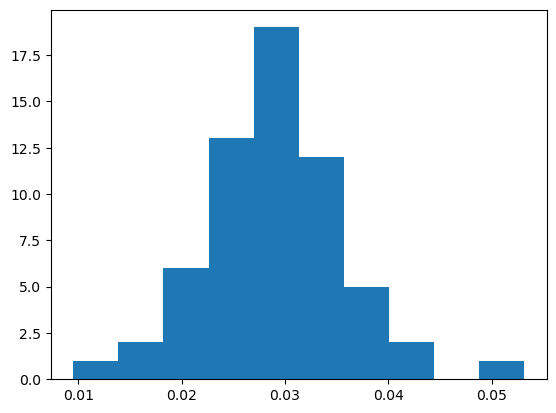

In [17]:
print(ttareun_df[ttareun_df.hour == 1].hour_bef_ozone.describe())
print(ttareun_df[ttareun_df.hour == 1].hour_bef_ozone.describe()['mean'])
plt.hist(ttareun_df[ttareun_df.hour == 1].hour_bef_ozone)
#잘 대체된 모습이다

In [18]:
check_na(ttareun_data,target=['?',0])
print('해당 데이터는 충분히 가능한 데이터임')
#바람이 안 불 수 있으므로 ㅇㅈ


hour열에 0값이 59개 있습니다.
hour_bef_precipitation열에 0값이 1411개 있습니다.
hour_bef_windspeed열에 0값이 3개 있습니다.
결측치가 있습니다
해당 데이터는 충분히 가능한 데이터임


---
#### 상관분석
##### 예측의 경우, 변수간 상관관계가 있을 시에는 제외하는 것이 좋다.
---

In [19]:
cor_df= ttareun_df.corr()


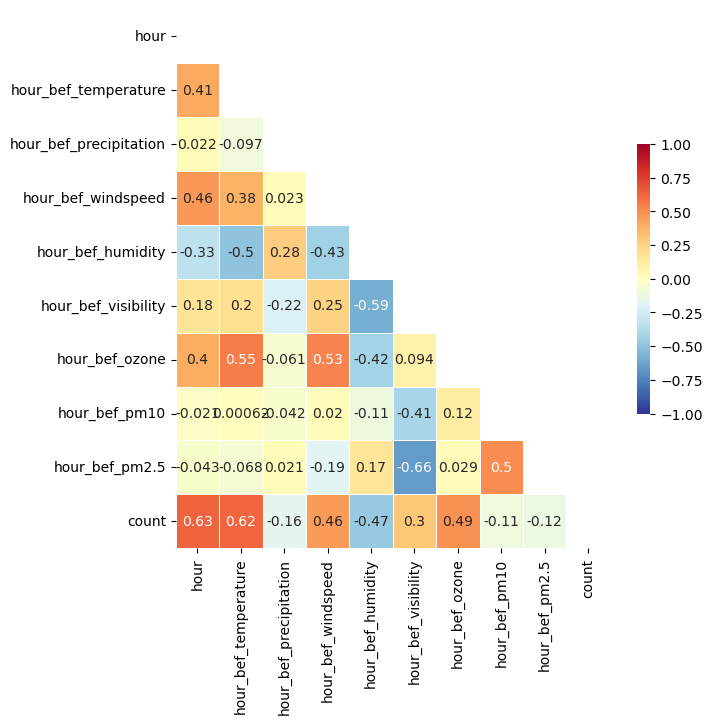

In [20]:
fig, ax = plt.subplots( figsize=(7,7) )

# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(cor_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# 히트맵을 그린다
sns.heatmap(cor_df, 
            cmap = 'RdYlBu_r', 
            annot = True,   # 실제 값을 표시한다
            mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .5},# 컬러바 크기 절반으로 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )  
plt.show()
#변수 간 상관관계가 커보이지는 않음
#온도 가 count의 가장 큰 상관관계를 가짐

---
### 이상치 및 분포 확인
---

<Figure size 1000x1000 with 0 Axes>

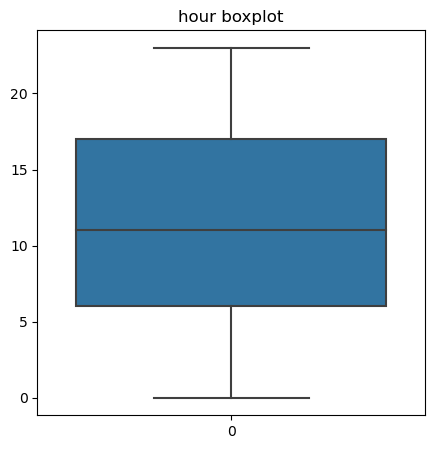

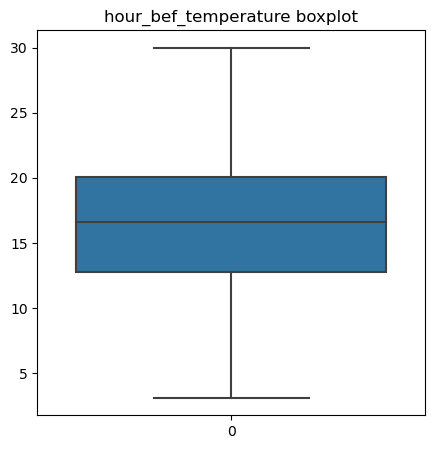

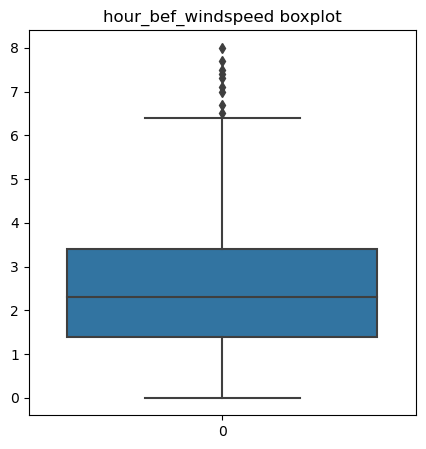

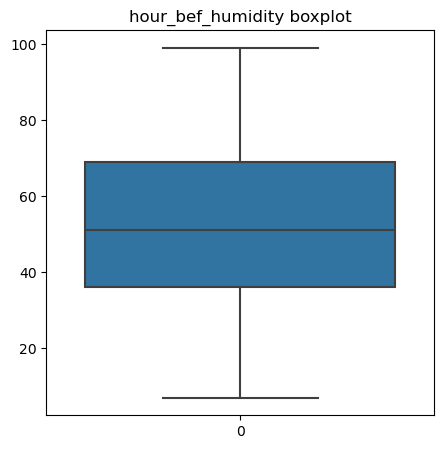

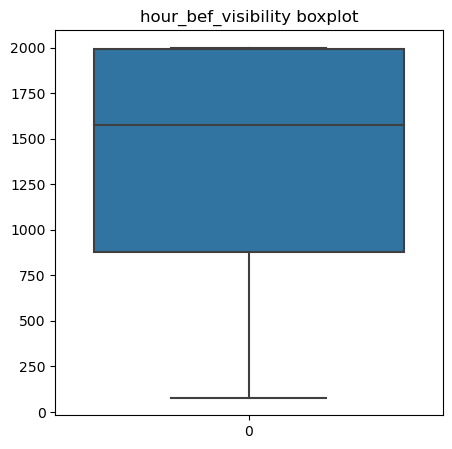

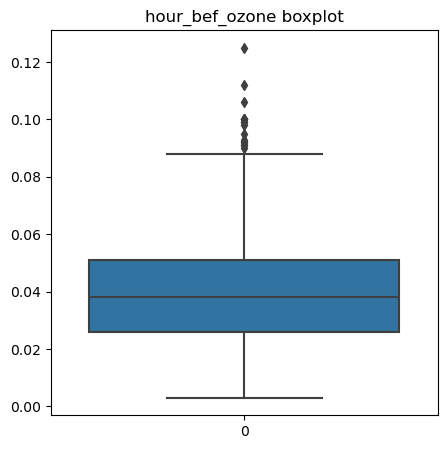

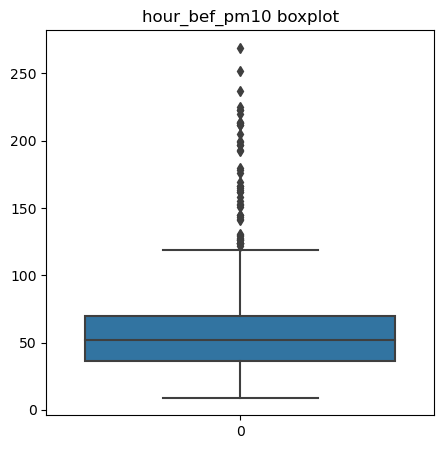

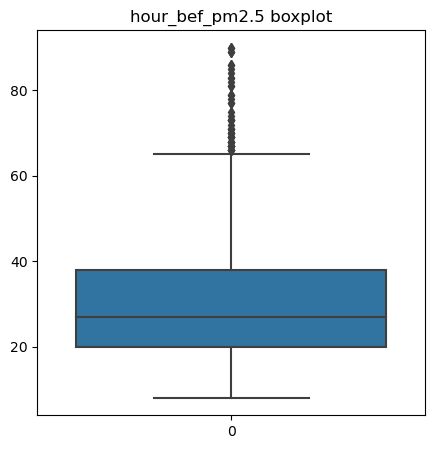

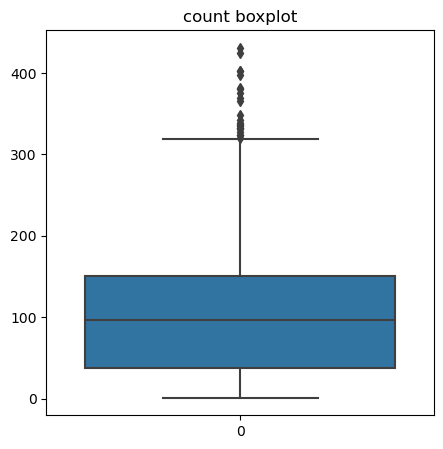

In [21]:
plt.figure(figsize=(10,10))
col_data = ttareun_df.drop(['hour_bef_precipitation'],axis=1)
                  
def check_box(data):
    for i in data.columns:
        plt.figure(figsize = (5,5))
        sns.boxplot(data=data[i])
        plt.title(f'{i} boxplot')
        plt.show()
check_box(col_data)
# 바람온도 미세먼지에서 이상치가 확인됨

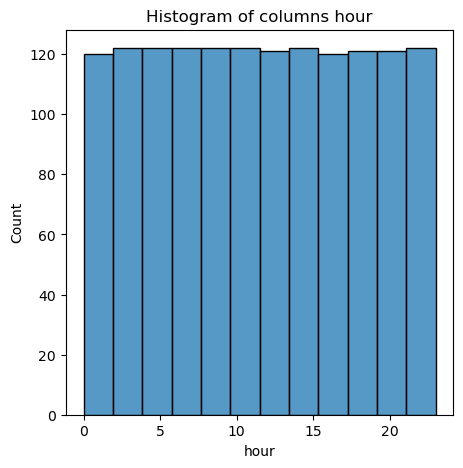

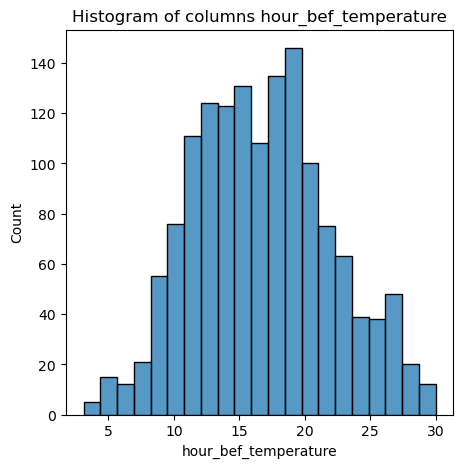

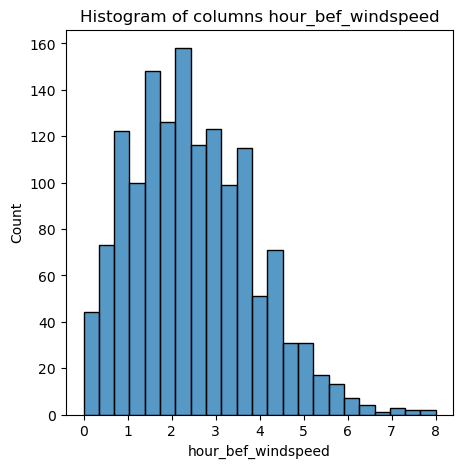

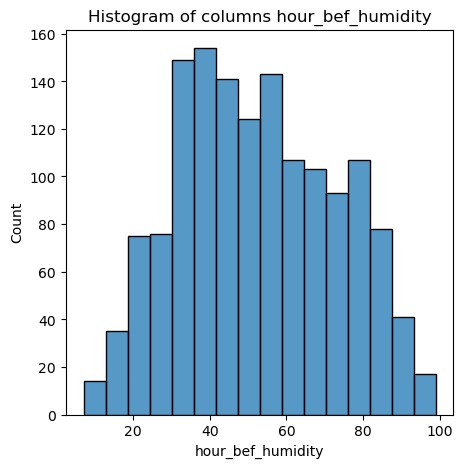

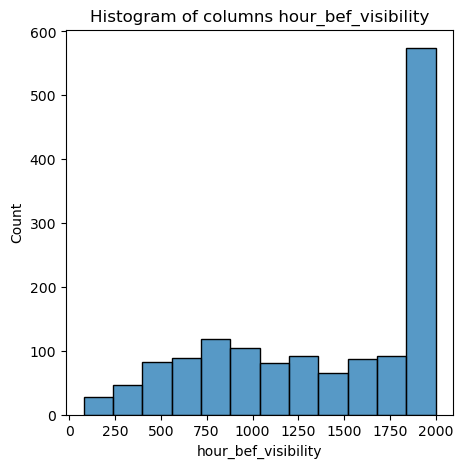

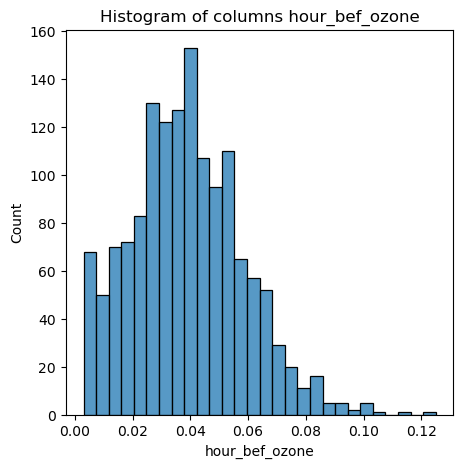

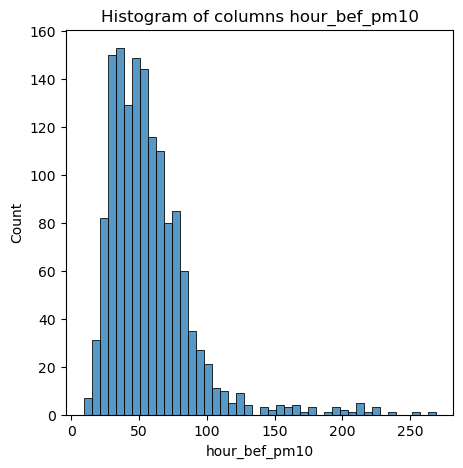

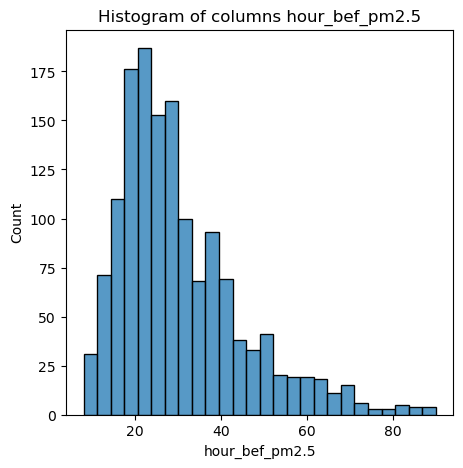

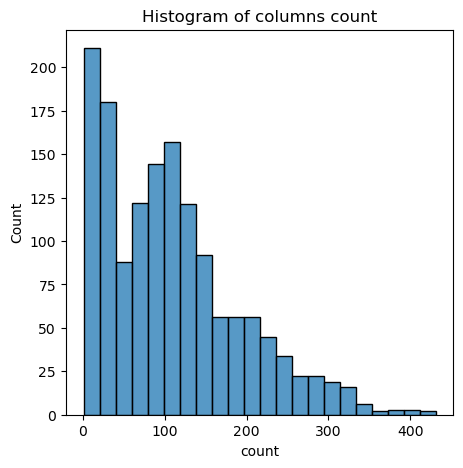

In [22]:
def check_distribution(data):
    for i in data.columns:
        plt.figure(figsize = (5,5))
        #열 데이터별 분포확인
        sns.histplot(data=data[i])
        # 그래프 타이틀 추가
        plt.title(f'Histogram of columns {i}')
        # 그래프 출력
        plt.show()
check_distribution(col_data)
#시간대의 분포가 균등!

In [98]:
ttareun_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1457 entries, 0 to 1456
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   hour                    1457 non-null   float64
 1   hour_bef_temperature    1457 non-null   float64
 2   hour_bef_precipitation  1457 non-null   float64
 3   hour_bef_windspeed      1457 non-null   float64
 4   hour_bef_humidity       1457 non-null   float64
 5   hour_bef_visibility     1457 non-null   float64
 6   hour_bef_ozone          1457 non-null   float64
 7   hour_bef_pm10           1457 non-null   float64
 8   hour_bef_pm2.5          1457 non-null   float64
 9   count                   1457 non-null   float64
dtypes: float64(10)
memory usage: 114.0 KB


In [99]:
#타겟, 피쳐분리
target_data = ttareun_df['count']
feature_data = ttareun_df.drop(['count','hour_bef_pm2.5'],axis =1)


In [100]:
#StandardScaler를 통해 scaling

ss = StandardScaler()
feature_fit = ss.fit_transform(feature_data)
feature_fit.shape

(1457, 8)

In [101]:
feature_data = pd.DataFrame(feature_fit, columns= feature_data.columns)
feature_data

,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10
0,1.229389,-0.079703,5.538403,-0.711364,1.805627,-1.422494,-0.614919,0.601359
1,0.217319,0.645854,-0.180557,-0.784073,-0.207789,-0.839236,0.166228,0.505286
2,-0.794752,-0.537950,-0.180557,-1.293035,1.314550,-0.039828,-0.302460,-0.807708
3,1.663134,-1.645380,-0.180557,0.161142,0.086857,-0.787772,0.062075,0.569335
4,0.940226,2.440655,-0.180557,1.688028,-2.221206,1.020331,0.947375,-0.967829
...,...,...,...,...,...,...,...,...
1452,-1.083915,0.015765,-0.180557,-0.638655,0.037749,1.020331,-0.406613,-0.647586
1453,-1.228496,-1.129852,-0.180557,0.960940,-0.355113,1.020331,0.009999,-0.743659
1454,-0.939333,0.302169,-0.180557,-0.420529,0.086857,1.020331,-1.552296,-0.871756
1455,1.373971,0.760416,-0.180557,0.888231,-0.747974,-0.017527,2.249287,0.441238


In [27]:
#outlier 확인

def check_outliers(df):
    for column_name in df.columns:
        upper_bound = 3.29  # 상한선  
        lower_bound = -3.29  # 하한선
        df1 = df[(df[column_name] <= lower_bound)] #하한 이상치
        df2 = df[df[column_name] >= upper_bound]  # 상한 이상치 확인
        print('하한 이상치')
        print(f'이상치 column_name: {column_name}')
        print(df1[column_name])
        print('상한 이상치')
        print(f'이상치 column_name: {column_name}')
        print(df2[column_name])
check_outliers(feature_data)

하한 이상치
이상치 column_name: hour
Series([], Name: hour, dtype: float64)
상한 이상치
이상치 column_name: hour
Series([], Name: hour, dtype: float64)
하한 이상치
이상치 column_name: hour_bef_temperature
Series([], Name: hour_bef_temperature, dtype: float64)
상한 이상치
이상치 column_name: hour_bef_temperature
Series([], Name: hour_bef_temperature, dtype: float64)
하한 이상치
이상치 column_name: hour_bef_precipitation
Series([], Name: hour_bef_precipitation, dtype: float64)
상한 이상치
이상치 column_name: hour_bef_precipitation
0       5.538403
15      5.538403
17      5.538403
19      5.538403
48      5.538403
59      5.538403
130     5.538403
154     5.538403
169     5.538403
222     5.538403
299     5.538403
306     5.538403
309     5.538403
323     5.538403
333     5.538403
344     5.538403
363     5.538403
380     5.538403
387     5.538403
436     5.538403
495     5.538403
507     5.538403
539     5.538403
583     5.538403
590     5.538403
605     5.538403
636     5.538403
692     5.538403
713     5.538403
718     5.538403
765

---
### 이상치 제거 X 예측
---

In [102]:
# 데이터 내 train, test split 시간대에 따라 분류
X_train, X_test, y_train, y_test = train_test_split(feature_data, target_data, test_size= 0.2, random_state=2,stratify=feature_data['hour'])

In [29]:
#적합 모델 찾기
#데이터
def allest(data, label,X_test,y_test,choose_type):
    rets = all_estimators(type_filter= choose_type)#분류 혹은 회귀
    result=[]
    for name, estimator_ in rets:
        try:
            model=estimator_()
            model.fit(data, label)
            # sc=model.score(data, label)
            # result.append((name, round(sc, 2)))
            pred = model.predict(X_test)
            print(model)
            print(model.get_params())
            print(r2_score(y_test,pred))
            print(mean_squared_error(y_test,pred))
            result.append((name, round(r2_score(y_test,pred), 2),round(mean_squared_error(y_test,pred))))
        except Exception:
            pass

    return result


In [30]:
result = allest(X_train, y_train,X_test,y_test,'regressor')

ARDRegression()
{'alpha_1': 1e-06, 'alpha_2': 1e-06, 'compute_score': False, 'copy_X': True, 'fit_intercept': True, 'lambda_1': 1e-06, 'lambda_2': 1e-06, 'n_iter': 300, 'threshold_lambda': 10000.0, 'tol': 0.001, 'verbose': False}
0.6180607758068892
2622.1214465099283
AdaBoostRegressor()
{'base_estimator': 'deprecated', 'estimator': None, 'learning_rate': 1.0, 'loss': 'linear', 'n_estimators': 50, 'random_state': None}
0.6338326589316821
2513.8429813150105
BaggingRegressor()
{'base_estimator': 'deprecated', 'bootstrap': True, 'bootstrap_features': False, 'estimator': None, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
0.7409680536281145
1778.3280136986302
BayesianRidge()
{'alpha_1': 1e-06, 'alpha_2': 1e-06, 'alpha_init': None, 'compute_score': False, 'copy_X': True, 'fit_intercept': True, 'lambda_1': 1e-06, 'lambda_2': 1e-06, 'lambda_init': None, 'n_iter': 300, 'tol': 0.001, 'verb

In [31]:
result

[('ARDRegression', 0.62, 2622),
 ('AdaBoostRegressor', 0.63, 2514),
 ('BaggingRegressor', 0.74, 1778),
 ('BayesianRidge', 0.62, 2616),
 ('DecisionTreeRegressor', 0.55, 3061),
 ('DummyRegressor', -0.0, 6866),
 ('ElasticNet', 0.6, 2765),
 ('ElasticNetCV', 0.62, 2610),
 ('ExtraTreeRegressor', 0.61, 2679),
 ('ExtraTreesRegressor', 0.8, 1387),
 ('GammaRegressor', 0.56, 3010),
 ('GaussianProcessRegressor', 0.49, 3507),
 ('GradientBoostingRegressor', 0.77, 1583),
 ('HistGradientBoostingRegressor', 0.76, 1645),
 ('HuberRegressor', 0.6, 2735),
 ('KNeighborsRegressor', 0.71, 1997),
 ('KernelRidge', -1.16, 14845),
 ('Lars', 0.62, 2620),
 ('LarsCV', 0.62, 2620),
 ('Lasso', 0.62, 2619),
 ('LassoCV', 0.62, 2620),
 ('LassoLars', 0.62, 2619),
 ('LassoLarsCV', 0.62, 2620),
 ('LassoLarsIC', 0.62, 2622),
 ('LinearRegression', 0.62, 2620),
 ('LinearSVR', 0.56, 3049),
 ('MLPRegressor', 0.63, 2560),
 ('NuSVR', 0.47, 3665),
 ('OrthogonalMatchingPursuit', 0.41, 4025),
 ('OrthogonalMatchingPursuitCV', 0.6, 273

In [32]:
sorted(result, key=lambda x : x[1], reverse=True)

[('ExtraTreesRegressor', 0.8, 1387),
 ('GradientBoostingRegressor', 0.77, 1583),
 ('RandomForestRegressor', 0.77, 1550),
 ('HistGradientBoostingRegressor', 0.76, 1645),
 ('BaggingRegressor', 0.74, 1778),
 ('KNeighborsRegressor', 0.71, 1997),
 ('PoissonRegressor', 0.65, 2415),
 ('AdaBoostRegressor', 0.63, 2514),
 ('MLPRegressor', 0.63, 2560),
 ('PLSRegression', 0.63, 2513),
 ('ARDRegression', 0.62, 2622),
 ('BayesianRidge', 0.62, 2616),
 ('ElasticNetCV', 0.62, 2610),
 ('Lars', 0.62, 2620),
 ('LarsCV', 0.62, 2620),
 ('Lasso', 0.62, 2619),
 ('LassoCV', 0.62, 2620),
 ('LassoLars', 0.62, 2619),
 ('LassoLarsCV', 0.62, 2620),
 ('LassoLarsIC', 0.62, 2622),
 ('LinearRegression', 0.62, 2620),
 ('Ridge', 0.62, 2619),
 ('RidgeCV', 0.62, 2617),
 ('SGDRegressor', 0.62, 2614),
 ('TransformedTargetRegressor', 0.62, 2620),
 ('ExtraTreeRegressor', 0.61, 2679),
 ('ElasticNet', 0.6, 2765),
 ('HuberRegressor', 0.6, 2735),
 ('OrthogonalMatchingPursuitCV', 0.6, 2739),
 ('TheilSenRegressor', 0.59, 2800),
 ('P

In [103]:
#GridsearchCV를 활용한 DecisionTreeRegressor
param = {'max_depth':[None,3,4,5,7,10], 'min_samples_split':[2,3,4,5,10,15], 'min_samples_leaf':[i for i in range(1,10)]}
DTR = DecisionTreeRegressor()
DTR.fit(X_train,y_train)
GrDTR = GridSearchCV(DTR,param_grid=param, cv = 5,refit=True)
GrDTR.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [None, 3, 4, 5, 7, 10],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'min_samples_split': [2, 3, 4, 5, 10, 15]})

In [104]:

best_model = GrDTR.best_estimator_
y_pred = best_model.predict(X_test)
print(r2_score(y_pred,y_test))
print(mean_squared_error(y_pred,y_test))

0.5617948089422978
2499.4202414914


In [87]:
DTR.score(X_train,y_train)

1.0

In [36]:
DTR.score(X_test,y_test)
#과적합 문제 발생

0.544631709882175

In [105]:
rfr = RandomForestRegressor()
rfr.fit(X_train,y_train)
pred = rfr.predict(X_test)
print(f'r2_score :{round(r2_score(pred, y_test),2)}')
print(f'rmse: {round(np.sqrt(mean_squared_error(pred, y_test)),2)}')


r2_score :0.71
rmse: 40.32


In [91]:
etr = ExtraTreeRegressor()
etr.fit(X_train,y_train)
pred = etr.predict(X_test)
print(f'r2_score :{round(r2_score(pred, y_test),2)}')
print(f'rmse: {round(np.sqrt(mean_squared_error(pred, y_test)),2)}')

r2_score :0.55
rmse: 55.63


#### 앙상블의 ExtraTreesRegressor()

In [89]:
etsr = ExtraTreesRegressor()
etsr.fit(X_train,y_train)
pred = etr.predict(X_test)
print(f'r2_score :{round(r2_score(pred, y_test),3)}')
print(f'rmse: {round(np.sqrt(mean_squared_error(pred, y_test)),3)}')

r2_score :-34.013
rmse: 131.084


In [50]:
param = {'bootstrap': [False,True], 'max_depth': [i for i in range(1,10)], 'max_leaf_nodes': [None, 1,3,5,10], 'min_samples_leaf': [i for i in range(1,10)], 'min_samples_split': [i for i in range(2,10)], 'n_estimators': [10,50,100]}
gridSrcv = GridSearchCV(etsr, param_grid= param, cv= 5, refit=True)
gridSrcv.fit(X_train,y_train)


GridSearchCV(cv=5, estimator=ExtraTreesRegressor(),
             param_grid={'bootstrap': [False, True],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'max_leaf_nodes': [None, 1, 3, 5, 10],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9],
                         'n_estimators': [10, 50, 100]})

In [52]:
best_model= gridSrcv.best_estimator_
pred = best_model.predict(X_test)
print(f'r2_score {round(r2_score(pred,y_test),3)}')
print(f'rmse: {round(np.sqrt(mean_squared_error(pred, y_test)),3)}')
print(f'best_model: {gridSrcv.best_estimator_}')

r2_score 0.689
rmse: 39.635
best_model: ExtraTreesRegressor(max_depth=9, min_samples_leaf=2, min_samples_split=4)


#### 위의 model이 높은 score를 기록함.

In [108]:
#test데이터를 적용해보자
ttareun_data_test = pd.read_csv('test.csv')
print(ttareun_data_test[ttareun_data_test['hour_bef_temperature'].isnull() == True])
#ttareun_data_test = ttareun_data_test.drop(ttareun_data[ttareun_data.hour_bef_temperature.isnull() == True].index)
#ttareun_data_test.drop(ttareun_data_test[ttareun_data_test['hour_bef_temperature'].isnull() ==True].index,inplace=True)

#남은 결측치 대체
#하기 전에 id와 index는 삭제
ttareun_test_df = ttareun_data_test.drop(['id','hour_bef_pm2.5'],axis=1)
#나머지 결측치 대체  IterativeImputer 
imputer = IterativeImputer()
ttareun_data_test_fill_na_array = imputer.fit_transform(ttareun_test_df)
ttareun_test_df = pd.DataFrame(ttareun_data_test_fill_na_array,columns=ttareun_test_df.columns)
ttareun_test_df.info()
#StandardScaling
ss = StandardScaler()
feature_fit = ss.fit_transform(ttareun_test_df)
feature_fit.shape
#allset()



       id  hour  hour_bef_temperature  hour_bef_precipitation  \
653  1943    19                   NaN                     NaN   

     hour_bef_windspeed  hour_bef_humidity  hour_bef_visibility  \
653                 NaN                NaN                  NaN   

     hour_bef_ozone  hour_bef_pm10  hour_bef_pm2.5  
653             NaN            NaN             NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715 entries, 0 to 714
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   hour                    715 non-null    float64
 1   hour_bef_temperature    715 non-null    float64
 2   hour_bef_precipitation  715 non-null    float64
 3   hour_bef_windspeed      715 non-null    float64
 4   hour_bef_humidity       715 non-null    float64
 5   hour_bef_visibility     715 non-null    float64
 6   hour_bef_ozone          715 non-null    float64
 7   hour_bef_pm10           715 non-null    fl

(715, 8)

In [76]:
submission= pd.read_csv('../Ttareun/sub/submission.csv')
submission['count'] = etsr.predict(feature_fit)
submission.to_csv('submission.csv')

In [72]:
submission= pd.read_csv('../sub/submission')
submission['count'] = best_model.predict(feature_fit)
submission.to_csv('submission.csv')

In [109]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)
pred=rf.predict(X_test)
r2_score(pred,y_test)
print(pred)
print(mean_squared_error(pred,y_test))
submission= pd.read_csv('../Ttareun/sub/submission.csv')
submission['count'] = rf.predict(feature_fit)
submission.to_csv('submission.csv')

[ 29.68 164.28  84.5   13.6   63.39 145.64  39.92 109.23  51.32  93.5
  93.86  25.22  11.87  38.46  56.8   86.34 108.38 162.09  19.95  99.32
 121.91  91.38  18.91 227.42  20.16 221.7   32.74  45.83 213.76  90.29
 262.4   30.64 155.68 154.14  91.97  16.99  15.04  24.56  89.06  75.74
  70.96  65.59 114.36  15.79  30.02  33.73 247.17 167.61 134.69  33.8
  28.5   82.87  27.79 112.63 131.3  154.9   12.61 244.58 105.05 190.57
 249.25  18.75  97.65  25.52  20.37 149.88  27.11 208.2  211.45 196.39
  90.11 121.21  85.14 181.4  179.29  98.01  17.33 188.25 242.92  19.54
 158.46 129.54 108.6  105.78 117.23   8.44 126.4  139.29 180.95 158.67
  69.75  14.62 205.83  79.52  50.55 114.09 138.44 169.88  14.75  88.56
  83.98  36.24  84.31 250.66 197.89 291.39  24.57 137.51   9.55 178.28
 196.87 135.32  12.1   20.49  95.52  26.56  12.4  113.73  23.66  24.13
 162.98 218.76  19.05 145.17  76.7   93.43  98.72 134.02 152.56  49.21
  81.77  16.38 109.54 290.88  70.82 102.77 144.79  84.23 200.96 109.68
 145.46 